In [1]:
%matplotlib inline


# Plotting data from a file

Plotting CPU usage values


In [2]:
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

from glob import glob
from sklearn.metrics import auc
from sklearn.model_selection import train_test_split

Load the data
============

In [3]:
state_transitions = pd.read_csv('state_snapshots_adaptive_2021_01_08.csv')
state_transitions.head()

,name,time,placementAction,cpuUsageMetrics,arrivalRate,throughput
0,state_snapshots,1610081835449000000,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0.086, 0.02, 0.241, 0.008, 0.327, 0.443, 0.98...",18304.333333,161397.66
1,state_snapshots,1610081865221000000,"[2, 17, 19, 5, 6, 22, 15, 1, 13, 20, 9, 4, 18,...","[0.01, 0.028, 0.018, 0.984, 0.066, 0.018, 0.05...",38553.666667,340664.89
2,state_snapshots,1610081895189000000,"[19, 13, 11, 3, 17, 7, 6, 20, 16, 5, 18, 1, 10...","[0.008, 0.004, 0.46, 0.984, 0.026, 0.012, 0.99...",39436.850000,349144.18
3,state_snapshots,1610081925198000000,"[14, 23, 17, 4, 7, 6, 13, 15, 9, 12, 0, 18, 10...","[0.006, 0.008, 0.046, 0.062, 0.046, 0.02, 0.07...",38324.650000,339366.20
4,state_snapshots,1610081955228000000,"[14, 17, 6, 23, 10, 5, 16, 20, 22, 15, 3, 21, ...","[0.002, 0.04, 0.014, 0.444, 0.331, 0.02, 0.044...",38969.850000,344588.33


In [4]:
placement_actions = state_transitions.placementAction.str.strip('[]').str.split(',', expand=True).astype(int)
placement_actions = placement_actions.add_prefix('assignment_v')
cpu_metrics = state_transitions.cpuUsageMetrics.str.strip('[]').str.split(',', expand=True)
cpu_metrics = cpu_metrics.add_prefix('cpu_')
processed_state_transitions = state_transitions.join(placement_actions).join(cpu_metrics)
processed_state_transitions.head(50)

,name,time,placementAction,cpuUsageMetrics,arrivalRate,throughput,assignment_v0,assignment_v1,assignment_v2,assignment_v3,...,cpu_14,cpu_15,cpu_16,cpu_17,cpu_18,cpu_19,cpu_20,cpu_21,cpu_22,cpu_23
0,state_snapshots,1610081835449000000,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0.086, 0.02, 0.241, 0.008, 0.327, 0.443, 0.98...",18304.333333,161397.66,1,2,3,4,...,0.024,0.01,0.014,0.044,0.056,0.066,0.1,0.014,0.058,0.012
1,state_snapshots,1610081865221000000,"[2, 17, 19, 5, 6, 22, 15, 1, 13, 20, 9, 4, 18,...","[0.01, 0.028, 0.018, 0.984, 0.066, 0.018, 0.05...",38553.666667,340664.89,2,17,19,5,...,0.026,0.376,0.024,0.014,0.014,0.98,0.066,0.06,0.004,0.538
2,state_snapshots,1610081895189000000,"[19, 13, 11, 3, 17, 7, 6, 20, 16, 5, 18, 1, 10...","[0.008, 0.004, 0.46, 0.984, 0.026, 0.012, 0.99...",39436.850000,349144.18,19,13,11,3,...,0.014,0.014,0.046,0.049,0.032,0.014,0.544,0.044,0.32,0.012
3,state_snapshots,1610081925198000000,"[14, 23, 17, 4, 7, 6, 13, 15, 9, 12, 0, 18, 10...","[0.006, 0.008, 0.046, 0.062, 0.046, 0.02, 0.07...",38324.650000,339366.20,14,23,17,4,...,0.994,0.024,0.992,0.028,0.014,0.006,0.066,0.611,0.365,0.008
4,state_snapshots,1610081955228000000,"[14, 17, 6, 23, 10, 5, 16, 20, 22, 15, 3, 21, ...","[0.002, 0.04, 0.014, 0.444, 0.331, 0.02, 0.044...",38969.850000,344588.33,14,17,6,23,...,0.062,0.012,0.024,0.01,0.99,0.0,0.629,0.038,0.002,0.33
5,state_snapshots,1610081985173000000,"[0, 3, 11, 1, 13, 14, 22, 10, 9, 2, 17, 19, 18...","[0.008, 0.06, 0.016, 0.01, 0.018, 0.048, 0.012...",37933.850000,335130.61,0,3,11,1,...,0.018,0.904,0.014,0.988,0.002,0.624,0.044,0.539,0.059,0.0
6,state_snapshots,1610082015179000000,"[8, 22, 23, 6, 9, 17, 5, 18, 14, 13, 3, 2, 12,...","[0.54, 0.034, 0.309, 0.028, 0.048, 0.06, 0.978...",36831.766667,325174.58,8,22,23,6,...,0.094,0.006,0.056,0.028,0.451,0.026,0.034,0.024,0.028,0.942
7,state_snapshots,1610082045204000000,"[23, 14, 7, 13, 18, 21, 5, 11, 10, 20, 9, 8, 1...","[0.04, 0.0, 0.992, 0.014, 0.03, 0.036, 0.992, ...",38679.583333,342060.81,23,14,7,13,...,0.024,0.028,0.06,0.008,0.016,0.323,0.07,0.064,0.07,0.024
8,state_snapshots,1610082075199000000,"[17, 8, 2, 19, 23, 21, 5, 12, 18, 20, 13, 22, ...","[0.006, 0.292, 0.046, 0.01, 0.103, 0.014, 0.01...",39902.700000,353442.14,17,8,2,19,...,0.547,0.932,0.044,0.008,0.386,0.012,0.524,0.044,0.002,0.034
9,state_snapshots,1610082105198000000,"[12, 6, 21, 10, 5, 11, 2, 22, 1, 15, 17, 9, 23...","[0.038, 0.325, 0.022, 0.98, 0.577, 0.014, 0.04...",39406.300000,349021.86,12,6,21,10,...,0.028,0.992,0.02,0.01,0.004,0.004,0.27,0.008,0.014,0.06


In [22]:
plot_state_transitions = pd.DataFrame(state_transitions.loc[
    state_transitions['throughput'] > 150000.0].groupby('placementAction')['throughput'].max()).reset_index()
plot_state_transitions

,placementAction,throughput
0,"[0, 12, 18, 1, 13, 2, 14, 3, 19, 7, 20, 8, 21,...",323628.13
1,"[0, 12, 18, 6, 19, 7, 20, 8, 21, 9, 22, 10, 23...",315385.10
2,"[0, 3, 11, 1, 13, 14, 22, 10, 9, 2, 17, 19, 18...",335130.61
3,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",161397.66
4,"[10, 11, 18, 2, 3, 15, 6, 20, 8, 12, 19, 1, 21...",305004.02
5,"[11, 10, 7, 8, 6, 21, 20, 1, 0, 23, 18, 9, 3, ...",349253.16
6,"[11, 6, 10, 8, 23, 2, 1, 20, 0, 16, 18, 22, 17...",257786.37
7,"[11, 6, 10, 9, 7, 1, 20, 21, 0, 23, 18, 3, 8, ...",346548.17
8,"[12, 6, 21, 10, 5, 11, 2, 22, 1, 15, 17, 9, 23...",349021.86
9,"[13, 22, 21, 14, 17, 20, 9, 12, 5, 11, 4, 10, ...",277537.16


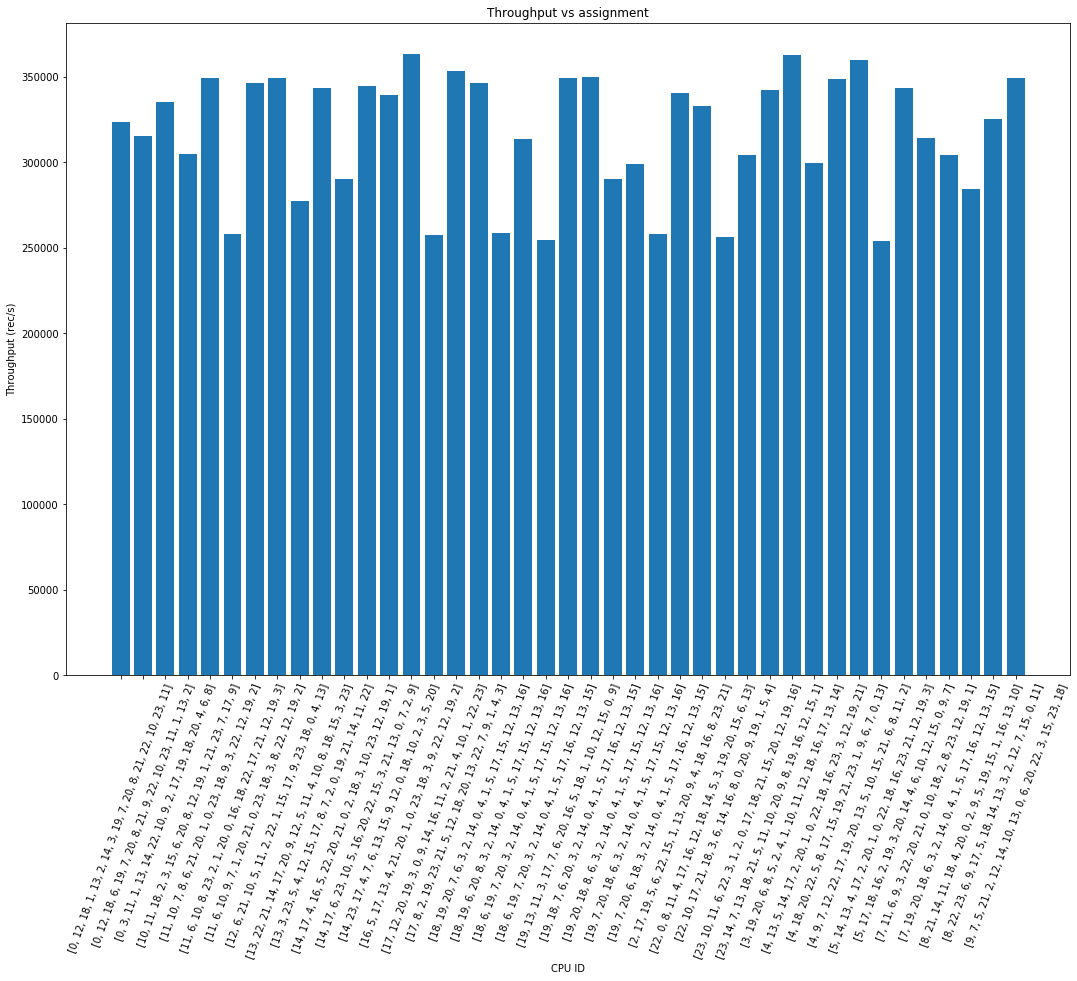

In [16]:
fig,ax = plt.subplots(figsize=(18,12))

ax.bar(plot_state_transitions['placementAction'], plot_state_transitions['throughput'])

ax.set(xlabel='CPU ID', ylabel='Throughput (rec/s)',
       title='Throughput vs assignment')
ax.tick_params(axis='x', rotation=70)
#ax.legend()
plt.savefig('placement_throughput_highlevel.png')
plt.show()

Task Manager CPU Usage
-----------



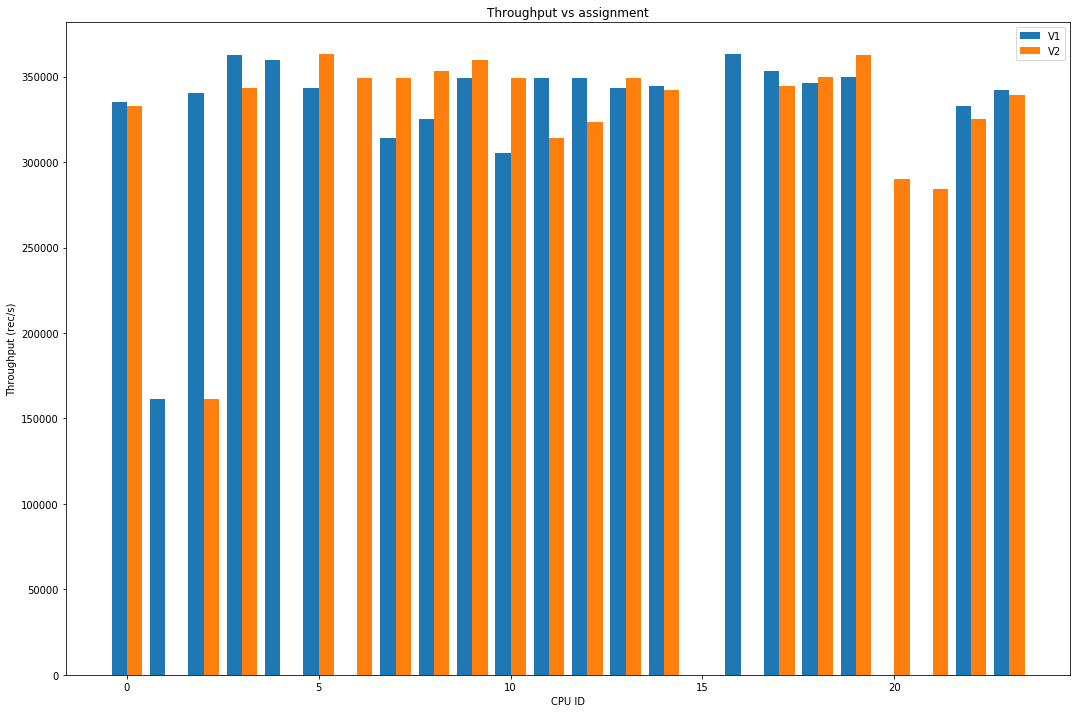

In [7]:
fig,ax = plt.subplots(figsize=(18,12))

width=0.4
ax.bar(processed_state_transitions['assignment_v0'] - width/2, processed_state_transitions['throughput'], width, label='V1')
ax.bar(processed_state_transitions['assignment_v1'] + width/2, processed_state_transitions['throughput'], width, label='V2')
#ax.plot(task_tot_cpu_data[2]['rel_time'], task_tot_cpu_data[2]['value'])
#ax.plot(task_tot_cpu_data[3]['rel_time'], task_tot_cpu_data[3]['value'])

ax.set(xlabel='CPU ID', ylabel='Throughput (rec/s)',
       title='Throughput vs assignment')
ax.tick_params(axis='x', rotation=0)
ax.legend()
plt.savefig('placement_throughput.png')
plt.show()

In [8]:
state_transitions.head()

,name,time,placementAction,cpuUsageMetrics,arrivalRate,throughput
0,state_snapshots,1610081835449000000,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0.086, 0.02, 0.241, 0.008, 0.327, 0.443, 0.98...",18304.333333,161397.66
1,state_snapshots,1610081865221000000,"[2, 17, 19, 5, 6, 22, 15, 1, 13, 20, 9, 4, 18,...","[0.01, 0.028, 0.018, 0.984, 0.066, 0.018, 0.05...",38553.666667,340664.89
2,state_snapshots,1610081895189000000,"[19, 13, 11, 3, 17, 7, 6, 20, 16, 5, 18, 1, 10...","[0.008, 0.004, 0.46, 0.984, 0.026, 0.012, 0.99...",39436.850000,349144.18
3,state_snapshots,1610081925198000000,"[14, 23, 17, 4, 7, 6, 13, 15, 9, 12, 0, 18, 10...","[0.006, 0.008, 0.046, 0.062, 0.046, 0.02, 0.07...",38324.650000,339366.20
4,state_snapshots,1610081955228000000,"[14, 17, 6, 23, 10, 5, 16, 20, 22, 15, 3, 21, ...","[0.002, 0.04, 0.014, 0.444, 0.331, 0.02, 0.044...",38969.850000,344588.33


In [9]:
state_transitions_for_training = state_transitions.join(placement_actions)
state_transitions_for_training.drop(columns=['name','time','placementAction','cpuUsageMetrics'], 
                                    inplace=True)
filtered_state_transitions = state_transitions_for_training.loc[state_transitions_for_training['throughput'] > 0.0]
throughput_col = filtered_state_transitions.pop('throughput')
filtered_state_transitions.insert(0, 'throughput', throughput_col)
filtered_state_transitions.to_csv('state_transitions_cured.csv', index=False)

In [10]:
filtered_state_transitions

,throughput,arrivalRate,assignment_v0,assignment_v1,assignment_v2,assignment_v3,assignment_v4,assignment_v5,assignment_v6,assignment_v7,assignment_v8,assignment_v9,assignment_v10,assignment_v11,assignment_v12,assignment_v13,assignment_v14,assignment_v15,assignment_v16
0,161397.66,18304.333333,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
1,340664.89,38553.666667,2,17,19,5,6,22,15,1,13,20,9,4,18,16,8,23,21
2,349144.18,39436.850000,19,13,11,3,17,7,6,20,16,5,18,1,10,12,15,0,9
3,339366.20,38324.650000,14,23,17,4,7,6,13,15,9,12,0,18,10,2,3,5,20
4,344588.33,38969.850000,14,17,6,23,10,5,16,20,22,15,3,21,13,0,7,2,9
5,335130.61,37933.850000,0,3,11,1,13,14,22,10,9,2,17,19,18,20,4,6,8
6,325174.58,36831.766667,8,22,23,6,9,17,5,18,14,13,3,2,12,7,15,0,11
7,342060.81,38679.583333,23,14,7,13,18,21,5,11,10,20,9,8,19,16,12,15,1
8,353442.14,39902.700000,17,8,2,19,23,21,5,12,18,20,13,22,7,9,1,4,3
9,349021.86,39406.300000,12,6,21,10,5,11,2,22,1,15,17,9,23,18,0,4,13


In [11]:
state_trans_train, state_trans_test = train_test_split(filtered_state_transitions, test_size=0.31)
state_trans_train.to_csv('state_transitions_cured_train.csv', index=False)

In [12]:
state_trans_test_final = state_trans_test.drop(columns=['throughput'])
state_trans_test_final.to_csv('state_transitions_cured_test.csv', index=False)

In [13]:
state_trans_train

,throughput,arrivalRate,assignment_v0,assignment_v1,assignment_v2,assignment_v3,assignment_v4,assignment_v5,assignment_v6,assignment_v7,assignment_v8,assignment_v9,assignment_v10,assignment_v11,assignment_v12,assignment_v13,assignment_v14,assignment_v15,assignment_v16
14,285849.17,32586.916667,0,12,18,1,13,2,14,3,19,7,20,8,21,22,10,23,11
18,277537.16,31676.550000,13,22,21,14,17,20,9,12,5,11,4,10,8,18,15,3,23
8,353442.14,39902.700000,17,8,2,19,23,21,5,12,18,20,13,22,7,9,1,4,3
33,304321.48,32920.650000,7,19,20,18,6,3,2,14,0,4,1,5,17,16,12,13,15
37,254032.43,27563.350000,5,14,13,4,17,2,20,1,0,22,18,16,23,21,12,19,3
7,342060.81,38679.583333,23,14,7,13,18,21,5,11,10,20,9,8,19,16,12,15,1
10,348522.04,39304.966667,4,18,20,22,5,8,17,15,19,21,23,1,9,6,7,0,13
16,305004.02,34627.516667,10,11,18,2,3,15,6,20,8,12,19,1,21,23,7,17,9
44,290053.76,31479.733333,0,12,18,6,19,7,20,8,21,9,22,10,23,11,1,13,2
21,362536.97,39450.083333,3,19,20,6,8,5,2,4,1,10,11,12,18,16,17,13,14


In [14]:
print("Done.")

Done.
